<a href="https://colab.research.google.com/github/fek17/research-project/blob/main/Copy_of_FYP_Rebuild_WO_CSTR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Importing Libraries**

In [ ]:
#@title
!pip install casadi
import numpy as np 
import matplotlib
import matplotlib.pyplot as plt 
from scipy.optimize import minimize 
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import random
from scipy.optimize import minimize
from scipy.optimize import fmin
from functools import partial

In [ ]:
#@title
# v2 includes shaping the TR with the curvature of the problem by a broyden update on derivatives
# and a BFGS update on the Hessian, however the TR becomes very small in some parts, so the approach
# does not seem to be too effective.

import time
import random
import numpy as np
import numpy.random as rnd
from scipy.spatial.distance import cdist
from scipy.optimize import minimize
from scipy.optimize import broyden1
from scipy import linalg
import scipy
import matplotlib.pyplot as plt
import functools
from matplotlib.patches import Ellipse

from casadi import *


def Benoit_Model(u):
    f = u[0] ** 2 + u[1] ** 2
    return f


def con1_model(u):
    g1 = 1. - u[0] + u[1] ** 2
    return -g1


def Benoit_System(u):
    f = u[0] ** 2 + u[1] ** 2 + u[0] * u[1] + np.random.normal(0., np.sqrt(1e-3))
    return f


def con1_system(u):
    g1 = 1. - u[0] + u[1] ** 2 + 2. * u[1] - 2. + np.random.normal(0., np.sqrt(1e-3))
    return -g1


def con1_system_tight(u):
    g1 = 1. - u[0] + u[1] ** 2 + 2. * u[1] + np.random.normal(0., np.sqrt(1e-3))
    return -g1


def Benoit_System_noiseless(u):
    f = u[0] ** 2 + u[1] ** 2 + u[0] * u[1]  # + np.random.normal(0., np.sqrt(1e-3))
    return f


def con1_system_noiseless(u):
    g1 = 1. - u[0] + u[1] ** 2 + 2. * u[1] - 2.  # + np.random.normal(0., np.sqrt(1e-3))
    return -g1


def con1_system_tight_noiseless(u):
    g1 = 1. - u[0] + u[1] ** 2 + 2. * u[1]  # + np.random.normal(0., np.sqrt(1e-3))
    return -g1


class WO_system:
    # Parameters
    Fa = 1.8275
    Mt = 2105.2
    # kinetic parameters
    phi1 = - 3.
    psi1 = -17.
    phi2 = - 4.
    psi2 = -29.
    # Reference temperature
    Tref = 110. + 273.15  # [=] K.

    def __init__(self):
        self.xd, self.xa, self.u, self.ODEeq, self.Aeq, self.states, self.algebraics, self.inputs = self.DAE_system()
        self.eval = self.integrator_system()

    def DAE_system(self):
        # Define vectors with names of states
        states = ['x']
        nd = len(states)
        xd = SX.sym('xd', nd)
        for i in range(nd):
            globals()[states[i]] = xd[i]

        # Define vectors with names of algebraic variables
        algebraics = ['Xa', 'Xb', 'Xc', 'Xe', 'Xp', 'Xg']
        na = len(algebraics)
        xa = SX.sym('xa', na)
        for i in range(na):
            globals()[algebraics[i]] = xa[i]

        inputs = ['Fb', 'Tr']
        nu = len(inputs)
        u = SX.sym("u", nu)
        for i in range(nu):
            globals()[inputs[i]] = u[i]

        # Reparametrization
        k1 = 1.6599e6 * np.exp(-6666.7 / (Tr + 273.15))
        k2 = 7.2117e8 * np.exp(-8333.3 / (Tr + 273.15))
        k3 = 2.6745e12 * np.exp(-11111. / (Tr + 273.15))

        # reaction rate
        Fr = Fa + Fb
        r1 = k1 * Xa * Xb * Mt
        r2 = k2 * Xb * Xc * Mt
        r3 = k3 * Xc * Xp * Mt

        # residual for x
        x_res = np.zeros((6, 1))
        x_res[0, 0] = (Fa - r1 - Fr * Xa) / Mt
        x_res[1, 0] = (Fb - r1 - r2 - Fr * Xb) / Mt
        x_res[2, 0] = (+ 2 * r1 - 2 * r2 - r3 - Fr * Xc) / Mt
        x_res[3, 0] = (+ 2 * r2 - Fr * Xe) / Mt
        x_res[4, 0] = (+   r2 - 0.5 * r3 - Fr * Xp) / Mt
        x_res[5, 0] = (+ 1.5 * r3 - Fr * Xg) / Mt
        # Define vectors with banes of input variables

        ODEeq = [0 * x]

        # Declare algebraic equations
        Aeq = []

        Aeq += [(Fa - r1 - Fr * Xa) / Mt]
        Aeq += [(Fb - r1 - r2 - Fr * Xb) / Mt]
        Aeq += [(+ 2 * r1 - 2 * r2 - r3 - Fr * Xc) / Mt]
        Aeq += [(+ 2 * r2 - Fr * Xe) / Mt]
        Aeq += [(+   r2 - 0.5 * r3 - Fr * Xp) / Mt]
        Aeq += [(+ 1.5 * r3 - Fr * Xg) / Mt]

        return xd, xa, u, ODEeq, Aeq, states, algebraics, inputs

    def integrator_system(self):
        """
        This function constructs the integrator to be suitable with casadi environment, for the equations of the model
        and the objective function with variable time step.
        inputs: NaN
        outputs: F: Function([x, u, dt]--> [xf, obj])
        """

        xd, xa, u, ODEeq, Aeq, states, algebraics, inputs = self.DAE_system()
        VV = Function('vfcn', [xa, u], [vertcat(*Aeq)], ['w0', 'u'], ['w'])
        solver = rootfinder('solver', 'newton', VV)

        return solver

    def WO_obj_sys_ca(self, u):
        x = self.eval(np.array([0.114805, 0.525604, 0.0260265, 0.207296, 0.0923376, 0.0339309]), u)
        Fb = u[0]
        Tr = u[1]
        Fa = 1.8275
        Fr = Fa + Fb

        obj = -(1043.38 * x[4] * Fr +
                20.92 * x[3] * Fr -
                79.23 * Fa -
                118.34 * Fb) + 0.5 * np.random.normal(0., 1)

        return obj

    def WO_obj_sys_ca_noise_less(self, u):
        x = self.eval(np.array([0.114805, 0.525604, 0.0260265, 0.207296, 0.0923376, 0.0339309]), u)
        Fb = u[0]
        Tr = u[1]
        Fa = 1.8275
        Fr = Fa + Fb

        obj = -(1043.38 * x[4] * Fr +
                20.92 * x[3] * Fr -
                79.23 * Fa -
                118.34 * Fb)  # + 0.5*np.random.normal(0., 1)

        return obj

    def WO_con1_sys_ca(self, u):
        x = self.eval(np.array([0.114805, 0.525604, 0.0260265, 0.207296, 0.0923376, 0.0339309]), u)
        pcon1 = x[0] - 0.12 + 5e-4 * np.random.normal(0., 1)

        return -pcon1.toarray()[0]

    def WO_con2_sys_ca(self, u):
        x = self.eval(np.array([0.114805, 0.525604, 0.0260265, 0.207296, 0.0923376, 0.0339309]), u)
        pcon2 = x[5] - 0.08 + 5e-4 * np.random.normal(0., 1)

        return -pcon2.toarray()[0]

    def WO_con1_sys_ca_noise_less(self, u):
        x = self.eval(np.array([0.114805, 0.525604, 0.0260265, 0.207296, 0.0923376, 0.0339309]), u)
        pcon1 = x[0] - 0.12  # + 5e-4*np.random.normal(0., 1)

        return -pcon1.toarray()[0]

    def WO_con2_sys_ca_noise_less(self, u):
        x = self.eval(np.array([0.114805, 0.525604, 0.0260265, 0.207296, 0.0923376, 0.0339309]), u)
        pcon2 = x[5] - 0.08  # + 5e-4*np.random.normal(0., 1)

        return -pcon2.toarray()[0]


class WO_model:
    # Parameters
    Fa = 1.8275
    Mt = 2105.2
    # kinetic parameters
    phi1 = - 3.
    psi1 = -17.
    phi2 = - 4.
    psi2 = -29.
    # Reference temperature
    Tref = 110. + 273.15  # [=] K.

    def __init__(self):
        self.xd, self.xa, self.u, self.ODEeq, self.Aeq, self.states, self.algebraics, self.inputs = self.DAE_model()
        self.eval = self.integrator_model()

    def DAE_model(self):
        # Define vectors with names of states
        states = ['x']
        nd = len(states)
        xd = SX.sym('xd', nd)
        for i in range(nd):
            globals()[states[i]] = xd[i]

        # Define vectors with names of algebraic variables
        algebraics = ['Xa', 'Xb', 'Xe', 'Xp', 'Xg']
        na = len(algebraics)
        xa = SX.sym('xa', na)
        for i in range(na):
            globals()[algebraics[i]] = xa[i]

        # Define vectors with banes of input variables
        inputs = ['Fb', 'Tr']
        nu = len(inputs)
        u = SX.sym("u", nu)
        for i in range(nu):
            globals()[inputs[i]] = u[i]

        k1 = np.exp(phi1) * np.exp((Tref / (Tr + 273.15) - 1) * psi1)
        k2 = np.exp(phi2) * np.exp((Tref / (Tr + 273.15) - 1) * psi2)

        # reaction rate
        Fr = Fa + Fb
        r1 = k1 * Xa * Xb * Xb * Mt
        r2 = k2 * Xa * Xb * Xp * Mt
        ODEeq = [0 * x]

        # Declare algebraic equations
        Aeq = []

        Aeq += [Fa - r1 - r2 - Fr * Xa]
        Aeq += [Fb - 2 * r1 - r2 - Fr * Xb]
        Aeq += [+ 2 * r1 - Fr * Xe]
        Aeq += [+   r1 - r2 - Fr * Xp]
        Aeq += [+ 3 * r2 - Fr * Xg]

        return xd, xa, u, ODEeq, Aeq, states, algebraics, inputs

    def integrator_model(self):
        """
        This function constructs the integrator to be suitable with casadi environment, for the equations of the model
        and the objective function with variable time step.
        inputs: NaN
        outputs: F: Function([x, u, dt]--> [xf, obj])
        """

        xd, xa, u, ODEeq, Aeq, states, algebraics, inputs = self.DAE_model()
        VV = Function('vfcn', [xa, u], [vertcat(*Aeq)], ['w0', 'u'], ['w'])
        solver = rootfinder('solver', 'newton', VV)

        # model = functools.partial(solver, np.zeros(np.shape(xa)))
        return solver

    def WO_obj_ca(self, u):
        x = self.eval(np.array([0.114805, 0.525604, 0.207296, 0.0923376, 0.0339309]), u)
        Fb = u[0]
        Tr = u[1]
        Fa = 1.8275
        Fr = Fa + Fb

        obj = -(1043.38 * x[3] * Fr +
                20.92 * x[2] * Fr -
                79.23 * Fa -
                118.34 * Fb)

        return obj

    def WO_con1_model_ca(self, u):
        x = self.eval(np.array([0.114805, 0.525604, 0.207296, 0.0923376, 0.0339309]), u)
        pcon1 = x[0] - 0.12  # + 5e-4*np.random.normal(1., 1)
        return -pcon1.toarray()[0]

    def WO_con2_model_ca(self, u):
        x = self.eval(np.array([0.114805, 0.525604, 0.207296, 0.0923376, 0.0339309]), u)
        pcon2 = x[4] - 0.08  # + 5e-4*np.random.normal(1., 1)
        return -pcon2.toarray()[0]


def con_empty(u):
    g1 = 0.
    return -g1


def obj_empty(u):
    f = 0.
    return f


#
# def DAE_model():
#     # Parameters
#     Fa = 1.8275
#     Mt = 2105.2
#     # kinetic parameters
#     phi1 = - 3.
#     psi1 = -17.
#     phi2 = - 4.
#     psi2 = -29.
#     # Reference temperature
#     Tref = 110. + 273.15  # [=] K.
#     # Define vectors with names of states
#     states = ['x']
#     nd = len(states)
#     xd = SX.sym('xd', nd)
#     for i in range(nd):
#         globals()[states[i]] = xd[i]
#
#     # Define vectors with names of algebraic variables
#     algebraics = ['Xa', 'Xb', 'Xe', 'Xp', 'Xg']
#     na = len(algebraics)
#     xa = SX.sym('xa', na)
#     for i in range(na):
#         globals()[algebraics[i]] = xa[i]
#
#     # Define vectors with banes of input variables
#     inputs = ['Fb', 'Tr']
#     nu = len(inputs)
#     u = SX.sym("u", nu)
#     for i in range(nu):
#         globals()[inputs[i]] = u[i]
#
#     k1 = np.exp(phi1) * np.exp((Tref / (Tr + 273.15) - 1) * psi1)
#     k2 = np.exp(phi2) * np.exp((Tref / (Tr + 273.15) - 1) * psi2)
#
#     # reaction rate
#     Fr = Fa + Fb
#     r1 = k1 * Xa * Xb * Xb * Mt
#     r2 = k2 * Xa * Xb * Xp * Mt
#     ODEeq = [0 * x]
#
#     # Declare algebraic equations
#     Aeq = []
#
#     Aeq += [Fa - r1 - r2 - Fr * Xa]
#     Aeq += [Fb - 2 * r1 - r2 - Fr * Xb]
#     Aeq += [+ 2 * r1 - Fr * Xe]
#     Aeq += [+   r1 - r2 - Fr * Xp]
#     Aeq += [+ 3 * r2 - Fr * Xg]
#
#     return xd, xa, u, ODEeq, Aeq, states, algebraics, inputs
#
#
# def integrator_model():
#     """
#     This function constructs the integrator to be suitable with casadi environment, for the equations of the model
#     and the objective function with variable time step.
#     inputs: NaN
#     outputs: F: Function([x, u, dt]--> [xf, obj])
#     """
#
#     xd, xa, u, ODEeq, Aeq, states, algebraics, inputs = DAE_model()
#     VV = Function('vfcn', [xa, u], [vertcat(*Aeq)], ['w0', 'u'], ['w'])
#     solver = rootfinder('solver', 'newton', VV)
#
#     # model = functools.partial(solver, np.zeros(np.shape(xa)))
#     return solver
#
#
# def WO_obj_ca(u):
#     solver = integrator_model()
#     x = solver(np.zeros(5), u)
#     Fb = u[0]
#     Tr = u[1]
#     Fa = 1.8275
#     Fr = Fa + Fb
#
#     obj = -(1043.38 * x[3] * Fr +
#             20.92 * x[2] * Fr -
#             79.23 * Fa -
#             118.34 * Fb)
#
#     return obj
#
#
# def WO_con1_model_ca(u):
#     solver = integrator_model()
#     x = solver(np.zeros(5), u)
#     pcon1 = x[0] - 0.12  # + 5e-4*np.random.normal(1., 1)
#     return -pcon1.toarray()[0]
#
#
# def WO_con2_model_ca(u):
#     solver = integrator_model()
#     x = solver(np.zeros(5), u)
#     pcon2 = x[4] - 0.08  # + 5e-4*np.random.normal(1., 1)
#     return -pcon2.toarray()[0]
#
#     # Parameters
#
#
#
#
# def DAE_system():
#     Fa = 1.8275
#     Mt = 2105.2
#     # kinetic parameters
#     phi1 = - 3.
#     psi1 = -17.
#     phi2 = - 4.
#     psi2 = -29.
#     # Reference temperature
#     Tref = 110. + 273.15  # [=] K.
#
#     # Define vectors with names of states
#     states = ['x']
#     nd = len(states)
#     xd = SX.sym('xd', nd)
#     for i in range(nd):
#         globals()[states[i]] = xd[i]
#
#     # Define vectors with names of algebraic variables
#     algebraics = ['Xa', 'Xb', 'Xc', 'Xe', 'Xp', 'Xg']
#     na = len(algebraics)
#     xa = SX.sym('xa', na)
#     for i in range(na):
#         globals()[algebraics[i]] = xa[i]
#
#     inputs = ['Fb', 'Tr']
#     nu = len(inputs)
#     u = SX.sym("u", nu)
#     for i in range(nu):
#         globals()[inputs[i]] = u[i]
#
#     # Reparametrization
#     k1 = 1.6599e6 * np.exp(-6666.7 / (Tr + 273.15))
#     k2 = 7.2117e8 * np.exp(-8333.3 / (Tr + 273.15))
#     k3 = 2.6745e12 * np.exp(-11111. / (Tr + 273.15))
#
#     # reaction rate
#     Fr = Fa + Fb
#     r1 = k1 * Xa * Xb * Mt
#     r2 = k2 * Xb * Xc * Mt
#     r3 = k3 * Xc * Xp * Mt
#
#     # residual for x
#     x_res = np.zeros((6, 1))
#     x_res[0, 0] = (Fa - r1 - Fr * Xa) / Mt
#     x_res[1, 0] = (Fb - r1 - r2 - Fr * Xb) / Mt
#     x_res[2, 0] = (+ 2 * r1 - 2 * r2 - r3 - Fr * Xc) / Mt
#     x_res[3, 0] = (+ 2 * r2 - Fr * Xe) / Mt
#     x_res[4, 0] = (+   r2 - 0.5 * r3 - Fr * Xp) / Mt
#     x_res[5, 0] = (+ 1.5 * r3 - Fr * Xg) / Mt
#     # Define vectors with banes of input variables
#
#     ODEeq = [0 * x]
#
#     # Declare algebraic equations
#     Aeq = []
#
#     Aeq += [(Fa - r1 - Fr * Xa) / Mt]
#     Aeq += [(Fb - r1 - r2 - Fr * Xb) / Mt]
#     Aeq += [(+ 2 * r1 - 2 * r2 - r3 - Fr * Xc) / Mt]
#     Aeq += [(+ 2 * r2 - Fr * Xe) / Mt]
#     Aeq += [(+   r2 - 0.5 * r3 - Fr * Xp) / Mt]
#     Aeq += [(+ 1.5 * r3 - Fr * Xg) / Mt]
#
#     return xd, xa, u, ODEeq, Aeq, states, algebraics, inputs
#
#
# def integrator_system():
#     """
#     This function constructs the integrator to be suitable with casadi environment, for the equations of the model
#     and the objective function with variable time step.
#     inputs: NaN
#     outputs: F: Function([x, u, dt]--> [xf, obj])
#     """
#
#     xd, xa, u, ODEeq, Aeq, states, algebraics, inputs = DAE_system()
#     VV = Function('vfcn', [xa, u], [vertcat(*Aeq)], ['w0', 'u'], ['w'])
#     solver = rootfinder('solver', 'newton', VV)
#
#     return solver
#
#
# def WO_obj_sys_ca(u):
#     solver = integrator_system()
#     x = solver(np.zeros(6), u)
#     Fb = u[0]
#     Tr = u[1]
#     Fa = 1.8275
#     Fr = Fa + Fb
#
#     obj = -(1043.38 * x[4] * Fr +
#             20.92 * x[3] * Fr -
#             79.23 * Fa -
#             118.34 * Fb)
#
#     return obj
#
#
# def WO_con1_sys_ca(u):
#     solver = integrator_system()
#     x = solver(np.zeros(6), u)
#     pcon1 = x[0] - 0.12  # + 5e-4*np.random.normal(1., 1)
#
#     return -pcon1
#
#
# def WO_con2_sys_ca(u):
#     solver = integrator_system()
#     x = solver(np.zeros(6), u)
#     pcon2 = x[5] - 0.08  # + 5e-4*np.random.normal(1., 1)
#
#     return -pcon2
#
options = {'disp': False, 'maxiter': 10000}  # solver options
# Parameters
Fa = 1.8275
Mt = 2105.2
# kinetic parameters
phi1 = - 3.
psi1 = -17.
phi2 = - 4.
psi2 = -29.
# Reference temperature
Tref = 110. + 273.15  # [=] K.


# --- residual function for model opt --- #
def WO_nonlinear_f_model_opt(x, u_):
    Fb = u_[0]
    Tr = u_[1]

    # states of the system
    Xa = x[0]  # Mass fraction
    Xb = x[1]  # Mass fraction
    Xe = x[2]  # Mass fraction
    Xp = x[3]  # Mass fraction
    Xg = x[4]  # Mass fraction

    # Reparametrization
    k1 = np.exp(phi1) * np.exp((Tref / (Tr + 273.15) - 1) * psi1)
    k2 = np.exp(phi2) * np.exp((Tref / (Tr + 273.15) - 1) * psi2)

    # reaction rate
    Fr = Fa + Fb
    r1 = k1 * Xa * Xb * Xb * Mt
    r2 = k2 * Xa * Xb * Xp * Mt

    # residual for x
    x_res = np.zeros((5, 1))
    x_res[0, 0] = Fa - r1 - r2 - Fr * Xa
    x_res[1, 0] = Fb - 2 * r1 - r2 - Fr * Xb
    x_res[2, 0] = + 2 * r1 - Fr * Xe
    x_res[3, 0] = +   r1 - r2 - Fr * Xp
    x_res[4, 0] = + 3 * r2 - Fr * Xg

    return np.sum(x_res ** 2)


# --- residual function for model --- #
def WO_nonlinear_f_model(u_, x):
    Fb = u_[0]
    Tr = u_[1]

    # states of the system
    Xa = x[0]  # Mass fraction
    Xb = x[1]  # Mass fraction
    Xe = x[2]  # Mass fraction
    Xp = x[3]  # Mass fraction
    Xg = x[4]  # Mass fraction

    # Reparametrization
    k1 = np.exp(phi1) * np.exp((Tref / (Tr + 273.15) - 1) * psi1)
    k2 = np.exp(phi2) * np.exp((Tref / (Tr + 273.15) - 1) * psi2)

    # reaction rate
    Fr = Fa + Fb
    r1 = k1 * Xa * Xb * Xb * Mt
    r2 = k2 * Xa * Xb * Xp * Mt

    # residual for x
    x_res = np.zeros((5, 1))
    x_res[0, 0] = Fa - r1 - r2 - Fr * Xa
    x_res[1, 0] = Fb - 2 * r1 - r2 - Fr * Xb
    x_res[2, 0] = + 2 * r1 - Fr * Xe
    x_res[3, 0] = +   r1 - r2 - Fr * Xp
    x_res[4, 0] = + 3 * r2 - Fr * Xg

    return x_res


# --- WO model objective --- #
def WO_Model_obj(u):
    x_guess = np.ones((5, 1)) * 0.2
    WO_f_model = functools.partial(WO_nonlinear_f_model, u)
    x_solved = broyden1(WO_f_model, x_guess, f_tol=1e-12)

    # definitions
    Fa = 1.8275
    Fb = u[0]
    Fr = Fa + Fb

    # calculating objective
    obj = -(1043.38 * x_solved[3, 0] * Fr +
            20.92 * x_solved[2, 0] * Fr -
            79.23 * Fa -
            118.34 * Fb)

    return obj


# --- WO model con1 --- #
def WO_Model_con1(u):
    x_guess = np.ones((5, 1)) * 0.2
    WO_f_model = functools.partial(WO_nonlinear_f_model, u)
    x_solved = broyden1(WO_f_model, x_guess, f_tol=1e-12)

    # calculating con1
    con1 = x_solved[0, 0] - 0.12

    return -con1


# --- WO model con1 opt --- #
def WO_Model_con1_opt(u):
    x_guess = np.ones((5, 1)) * 0.2

    res = minimize(WO_nonlinear_f_model_opt, x_guess, args=(u),
                   method='BFGS', options=options, tol=1e-12)
    x_solved = res.x

    # calculating con1
    con1 = x_solved[0] - 0.12

    return -con1


# --- WO model con2 --- #
def WO_Model_con2(u):
    x_guess = np.ones((5, 1)) * 0.2
    WO_f_model = functools.partial(WO_nonlinear_f_model, u)
    x_solved = broyden1(WO_f_model, x_guess, f_tol=1e-12)

    # calculating con1
    con2 = x_solved[4, 0] - 0.08

    return -con2


# --- WO model con2 opt --- #
def WO_Model_con2_opt(u):
    x_guess = np.ones((5, 1)) * 0.2
    res = minimize(WO_nonlinear_f_model_opt, x_guess, args=(u),
                   method='BFGS', options=options, tol=1e-12)
    x_solved = res.x

    # calculating con1
    con2 = x_solved[4] - 0.08

    return -con2
    # Parameters


Fa = 1.8275
Mt = 2105.2
# kinetic parameters
phi1 = - 3.
psi1 = -17.
phi2 = - 4.
psi2 = -29.
# Reference temperature
Tref = 110. + 273.15  # [=] K.


def DAE_system():
    # Define vectors with names of states
    states = ['x']
    nd = len(states)
    xd = SX.sym('xd', nd)
    for i in range(nd):
        globals()[states[i]] = xd[i]

    # Define vectors with names of algebraic variables
    algebraics = ['Xa', 'Xb', 'Xc', 'Xe', 'Xp', 'Xg']
    na = len(algebraics)
    xa = SX.sym('xa', na)
    for i in range(na):
        globals()[algebraics[i]] = xa[i]

    inputs = ['Fb', 'Tr']
    nu = len(inputs)
    u = SX.sym("u", nu)
    for i in range(nu):
        globals()[inputs[i]] = u[i]

    # Reparametrization
    k1 = 1.6599e6 * np.exp(-6666.7 / (Tr + 273.15))
    k2 = 7.2117e8 * np.exp(-8333.3 / (Tr + 273.15))
    k3 = 2.6745e12 * np.exp(-11111. / (Tr + 273.15))

    # reaction rate
    Fr = Fa + Fb
    r1 = k1 * Xa * Xb * Mt
    r2 = k2 * Xb * Xc * Mt
    r3 = k3 * Xc * Xp * Mt

    # residual for x
    x_res = np.zeros((6, 1))
    x_res[0, 0] = (Fa - r1 - Fr * Xa) / Mt
    x_res[1, 0] = (Fb - r1 - r2 - Fr * Xb) / Mt
    x_res[2, 0] = (+ 2 * r1 - 2 * r2 - r3 - Fr * Xc) / Mt
    x_res[3, 0] = (+ 2 * r2 - Fr * Xe) / Mt
    x_res[4, 0] = (+   r2 - 0.5 * r3 - Fr * Xp) / Mt
    x_res[5, 0] = (+ 1.5 * r3 - Fr * Xg) / Mt
    # Define vectors with banes of input variables

    ODEeq = [0 * x]

    # Declare algebraic equations
    Aeq = []

    Aeq += [(Fa - r1 - Fr * Xa) / Mt]
    Aeq += [(Fb - r1 - r2 - Fr * Xb) / Mt]
    Aeq += [(+ 2 * r1 - 2 * r2 - r3 - Fr * Xc) / Mt]
    Aeq += [(+ 2 * r2 - Fr * Xe) / Mt]
    Aeq += [(+   r2 - 0.5 * r3 - Fr * Xp) / Mt]
    Aeq += [(+ 1.5 * r3 - Fr * Xg) / Mt]

    return xd, xa, u, ODEeq, Aeq, states, algebraics, inputs


def integrator_system():
    """
    This function constructs the integrator to be suitable with casadi environment, for the equations of the model
    and the objective function with variable time step.
    inputs: NaN
    outputs: F: Function([x, u, dt]--> [xf, obj])
    """

    xd, xa, u, ODEeq, Aeq, states, algebraics, inputs = DAE_system()
    VV = Function('vfcn', [xa, u], [vertcat(*Aeq)], ['w0', 'u'], ['w'])
    solver = rootfinder('solver', 'newton', VV)

    return solver


def WO_obj_sys_ca(u):
    solver = integrator_system()
    x = solver(np.zeros(6), u)
    Fb = u[0]
    Tr = u[1]
    Fa = 1.8275
    Fr = Fa + Fb

    obj = -(1043.38 * x[4] * Fr +
            20.92 * x[3] * Fr -
            79.23 * Fa -
            118.34 * Fb)

    return obj


def WO_con1_sys_ca(u):
    solver = integrator_system()
    x = solver(np.zeros(6), u)
    pcon1 = x[0] - 0.12  # + 5e-4*np.random.normal(1., 1)

    return -pcon1.toarray()[0]


def WO_con2_sys_ca(u):
    solver = integrator_system()
    x = solver(np.zeros(6), u)
    pcon2 = x[5] - 0.08  # + 5e-4*np.random.normal(1., 1)

    return -pcon2.toarray()[0]

In [ ]:
#@title
#SOBOL sequencing from https://people.sc.fsu.edu/~jburkardt/py_src/sobol/sobol.py
from numpy import *
def i4_sobol_generate ( m, n, skip ):

#*****************************************************************************80
#
## I4_SOBOL_GENERATE generates a Sobol dataset.
#
#  Licensing:
#
#    This code is distributed under the MIT license.
#
#  Modified:
#
#    22 February 2011
#
#  Author:
#
#    Original MATLAB version by John Burkardt.
#    PYTHON version by Corrado Chisari
#
#  Parameters:
#
#    Input, integer M, the spatial dimension.
#
#    Input, integer N, the number of points to generate.
#
#    Input, integer SKIP, the number of initial points to skip.
#
#    Output, real R(M,N), the points.
#
	r=zeros((m,n))
	for j in range (1, n+1):
		seed = skip + j - 2
		[ r[0:m,j-1], seed ] = i4_sobol ( m, seed )
	return r

def i4_sobol ( dim_num, seed ):

#*****************************************************************************80
#
## I4_SOBOL generates a new quasirandom Sobol vector with each call.
#
#  Discussion:
#
#    The routine adapts the ideas of Antonov and Saleev.
#
#  Licensing:
#
#    This code is distributed under the MIT license.
#
#  Modified:
#
#    22 February 2011
#
#  Author:
#
#    Original FORTRAN77 version by Bennett Fox.
#    MATLAB version by John Burkardt.
#    PYTHON version by Corrado Chisari
#
#  Reference:
#
#    Antonov, Saleev,
#    USSR Computational Mathematics and Mathematical Physics,
#    olume 19, 1980, pages 252 - 256.
#
#    Paul Bratley, Bennett Fox,
#    Algorithm 659:
#    Implementing Sobol's Quasirandom Sequence Generator,
#    ACM Transactions on Mathematical Software,
#    Volume 14, Number 1, pages 88-100, 1988.
#
#    Bennett Fox,
#    Algorithm 647:
#    Implementation and Relative Efficiency of Quasirandom 
#    Sequence Generators,
#    ACM Transactions on Mathematical Software,
#    Volume 12, Number 4, pages 362-376, 1986.
#
#    Ilya Sobol,
#    USSR Computational Mathematics and Mathematical Physics,
#    Volume 16, pages 236-242, 1977.
#
#    Ilya Sobol, Levitan, 
#    The Production of Points Uniformly Distributed in a Multidimensional 
#    Cube (in Russian),
#    Preprint IPM Akad. Nauk SSSR, 
#    Number 40, Moscow 1976.
#
#  Parameters:
#
#    Input, integer DIM_NUM, the number of spatial dimensions.
#    DIM_NUM must satisfy 1 <= DIM_NUM <= 40.
#
#    Input/output, integer SEED, the "seed" for the sequence.
#    This is essentially the index in the sequence of the quasirandom
#    value to be generated.	On output, SEED has been set to the
#    appropriate next value, usually simply SEED+1.
#    If SEED is less than 0 on input, it is treated as though it were 0.
#    An input value of 0 requests the first (0-th) element of the sequence.
#
#    Output, real QUASI(DIM_NUM), the next quasirandom vector.
#
	global atmost
	global dim_max
	global dim_num_save
	global initialized
	global lastq
	global log_max
	global maxcol
	global poly
	global recipd
	global seed_save
	global v

	if ( not 'initialized' in globals().keys() ):
		initialized = 0
		dim_num_save = -1

	if ( not initialized or dim_num != dim_num_save ):
		initialized = 1
		dim_max = 40
		dim_num_save = -1
		log_max = 30
		seed_save = -1
#
#	Initialize (part of) V.
#
		v = zeros((dim_max,log_max))
		v[0:40,0] = transpose([ \
			1, 1, 1, 1, 1, 1, 1, 1, 1, 1, \
			1, 1, 1, 1, 1, 1, 1, 1, 1, 1, \
			1, 1, 1, 1, 1, 1, 1, 1, 1, 1, \
			1, 1, 1, 1, 1, 1, 1, 1, 1, 1 ])

		v[2:40,1] = transpose([ \
			1, 3, 1, 3, 1, 3, 3, 1, \
			3, 1, 3, 1, 3, 1, 1, 3, 1, 3, \
			1, 3, 1, 3, 3, 1, 3, 1, 3, 1, \
			3, 1, 1, 3, 1, 3, 1, 3, 1, 3 ])

		v[3:40,2] = transpose([ \
			7, 5, 1, 3, 3, 7, 5, \
			5, 7, 7, 1, 3, 3, 7, 5, 1, 1, \
			5, 3, 3, 1, 7, 5, 1, 3, 3, 7, \
			5, 1, 1, 5, 7, 7, 5, 1, 3, 3 ])

		v[5:40,3] = transpose([ \
			1, 7, 9,13,11, \
			1, 3, 7, 9, 5,13,13,11, 3,15, \
			5, 3,15, 7, 9,13, 9, 1,11, 7, \
			5,15, 1,15,11, 5, 3, 1, 7, 9 ])
	
		v[7:40,4] = transpose([ \
			9, 3,27, \
			15,29,21,23,19,11,25, 7,13,17, \
			1,25,29, 3,31,11, 5,23,27,19, \
			21, 5, 1,17,13, 7,15, 9,31, 9 ])

		v[13:40,5] = transpose([ \
							37,33, 7, 5,11,39,63, \
		 27,17,15,23,29, 3,21,13,31,25, \
			9,49,33,19,29,11,19,27,15,25 ])

		v[19:40,6] = transpose([ \
			13, \
			33,115, 41, 79, 17, 29,119, 75, 73,105, \
			7, 59, 65, 21,	3,113, 61, 89, 45,107 ])

		v[37:40,7] = transpose([ \
			7, 23, 39 ])
#
#	Set POLY.
#
		poly= [ \
			1,	 3,	 7,	11,	13,	19,	25,	37,	59,	47, \
			61,	55,	41,	67,	97,	91, 109, 103, 115, 131, \
			193, 137, 145, 143, 241, 157, 185, 167, 229, 171, \
			213, 191, 253, 203, 211, 239, 247, 285, 369, 299 ]

		atmost = 2**log_max - 1
#
#	Find the number of bits in ATMOST.
#
		maxcol = i4_bit_hi1 ( atmost )
#
#	Initialize row 1 of V.
#
		v[0,0:maxcol] = 1

#
#	Things to do only if the dimension changed.
#
	if ( dim_num != dim_num_save ):
#
#	Check parameters.
#
		if ( dim_num < 1 or dim_max < dim_num ):
			print ( 'I4_SOBOL - Fatal error!' )
			print ( '	The spatial dimension DIM_NUM should satisfy:' )
			print ( '		1 <= DIM_NUM <= %d'%dim_max )
			print ( '	But this input value is DIM_NUM = %d'%dim_num )
			return

		dim_num_save = dim_num
#
#	Initialize the remaining rows of V.
#
		for i in range(2 , dim_num+1):
#
#	The bits of the integer POLY(I) gives the form of polynomial I.
#
#	Find the degree of polynomial I from binary encoding.
#
			j = poly[i-1]
			m = 0
			while ( 1 ):
				j = math.floor ( j / 2. )
				if ( j <= 0 ):
					break
				m = m + 1
#
#	Expand this bit pattern to separate components of the logical array INCLUD.
#
			j = poly[i-1]
			includ=zeros(m)
			for k in range(m, 0, -1):
				j2 = math.floor ( j / 2. )
				includ[k-1] =  (j != 2 * j2 )
				j = j2
#
#	Calculate the remaining elements of row I as explained
#	in Bratley and Fox, section 2.
#
			for j in range( m+1, maxcol+1 ):
				newv = v[i-1,j-m-1]
				l = 1
				for k in range(1, m+1):
					l = 2 * l
					if ( includ[k-1] ):
						newv = bitwise_xor ( int(newv), int(l * v[i-1,j-k-1]) )
				v[i-1,j-1] = newv
#
#	Multiply columns of V by appropriate power of 2.
#
		l = 1
		for j in range( maxcol-1, 0, -1):
			l = 2 * l
			v[0:dim_num,j-1] = v[0:dim_num,j-1] * l
#
#	RECIPD is 1/(common denominator of the elements in V).
#
		recipd = 1.0 / ( 2 * l )
		lastq=zeros(dim_num)

	seed = int(math.floor ( seed ))

	if ( seed < 0 ):
		seed = 0

	if ( seed == 0 ):
		l = 1
		lastq=zeros(dim_num)

	elif ( seed == seed_save + 1 ):
#
#	Find the position of the right-hand zero in SEED.
#
		l = i4_bit_lo0 ( seed )

	elif ( seed <= seed_save ):

		seed_save = 0
		l = 1
		lastq=zeros(dim_num)

		for seed_temp in range( int(seed_save), int(seed)):
			l = i4_bit_lo0 ( seed_temp )
			for i in range(1 , dim_num+1):
				lastq[i-1] = bitwise_xor ( int(lastq[i-1]), int(v[i-1,l-1]) )

		l = i4_bit_lo0 ( seed )

	elif ( seed_save + 1 < seed ):

		for seed_temp in range( int(seed_save + 1), int(seed) ):
			l = i4_bit_lo0 ( seed_temp )
			for i in range(1, dim_num+1):
				lastq[i-1] = bitwise_xor ( int(lastq[i-1]), int(v[i-1,l-1]) )

		l = i4_bit_lo0 ( seed )
#
#	Check that the user is not calling too many times!
#
	if ( maxcol < l ):
		print ( 'I4_SOBOL - Fatal error!' )
		print ( '	Too many calls!' )
		print ( '	MAXCOL = %d\n'%maxcol )
		print ( '	L =			%d\n'%l )
		return
#
#	Calculate the new components of QUASI.
#
	quasi=zeros(dim_num)
	for i in range( 1, dim_num+1):
		quasi[i-1] = lastq[i-1] * recipd
		lastq[i-1] = bitwise_xor ( int(lastq[i-1]), int(v[i-1,l-1]) )

	seed_save = seed
	seed = seed + 1

	return [ quasi, seed ]


def i4_bit_hi1 ( n ) :

#*****************************************************************************80
#
## I4_BIT_HI1 returns the position of the high 1 bit base 2 in an I4.
#
#  Discussion:
#
#    An I4 is an integer ( kind = 4 ) value.
#
#  Example:
#
#       N    Binary    Hi 1
#    ----    --------  ----
#       0           0     0
#       1           1     1
#       2          10     2
#       3          11     2
#       4         100     3
#       5         101     3
#       6         110     3
#       7         111     3
#       8        1000     4
#       9        1001     4
#      10        1010     4
#      11        1011     4
#      12        1100     4
#      13        1101     4
#      14        1110     4
#      15        1111     4
#      16       10000     5
#      17       10001     5
#    1023  1111111111    10
#    1024 10000000000    11
#    1025 10000000001    11
#
#  Licensing:
#
#    This code is distributed under the GNU LGPL license.
#
#  Modified:
#
#    26 October 2014
#
#  Author:
#
#    John Burkardt
#
#  Parameters:
#
#    Input, integer N, the integer to be measured.
#    N should be nonnegative.  If N is nonpositive, the function
#    will always be 0.
#
#    Output, integer BIT, the position of the highest bit.
#
  i = n
  bit = 0

  while ( True ):

    if ( i <= 0 ):
      break

    bit = bit + 1
    i = i // 2

  return bit

def i4_bit_lo0 ( n ):

#*****************************************************************************80
#
## I4_BIT_LO0 returns the position of the low 0 bit base 2 in an I4.
#
#  Discussion:
#
#    An I4 is an integer ( kind = 4 ) value.
#
#  Example:
#
#       N    Binary    Lo 0
#    ----    --------  ----
#       0           0     1
#       1           1     2
#       2          10     1
#       3          11     3
#       4         100     1
#       5         101     2
#       6         110     1
#       7         111     4
#       8        1000     1
#       9        1001     2
#      10        1010     1
#      11        1011     3
#      12        1100     1
#      13        1101     2
#      14        1110     1
#      15        1111     5
#      16       10000     1
#      17       10001     2
#    1023  1111111111    11
#    1024 10000000000     1
#    1025 10000000001     2
#
#  Licensing:
#
#    This code is distributed under the GNU LGPL license.
#
#  Modified:
#
#    08 February 2018
#
#  Author:
#
#    John Burkardt
#
#  Parameters:
#
#    Input, integer N, the integer to be measured.
#    N should be nonnegative.
#
#    Output, integer BIT, the position of the low 1 bit.
#
  bit = 0
  i = n

  while ( True ):

    bit = bit + 1
    i2 = i // 2

    if ( i == 2 * i2 ):
      break

    i = i2

  return bit


**Functions**

In [ ]:
def sobol_sample(x_lb, x_ub, n_s): 
  "generates n_s pseudorandom floats between x_lb and x_ub as part of the sobol sequence"
  x1_lb, x2_lb = x_lb
  x1_ub, x2_ub = x_ub
  x_sample = i4_sobol_generate(2, n_s, 1);

  x_sample[0] = x_sample[0] * (x1_ub - x1_lb) + x1_lb
  x_sample[1] = x_sample[1] * (x2_ub - x2_lb) + x2_lb

  return x_sample

#quadratic proxy/surrogate functions
def f_approx(x, coeffs): 
  "quadratic proxy function to approximate the model function"
  a,b,c,d,e = coeffs
  f_approx = a*x[0]**2 + b*x[1]**2 + c*x[0] + d*x[1] + e  
  return (f_approx)

def phi_f(x, coeffs):
  "quadratic proxy function to approximate epsilon f, the error between the plant and the model"
  a,b,c,d,e = coeffs
  phi_f = a*x[0]**2 + b*x[1]**2 + c*x[0] + d*x[1] + e  
  return (phi_f) 

#trust region functions
def trust_constraint(x):
  "constraint for trust region to help find minima subject to bound length"
  return (delta_k - np.linalg.norm(x-x_k))

def adjust_trust(delta_k,x_k,x_new,coeffs):
  "adjusts the trust region based on nocedal & wright's algorithm"
  #note- you may decide to remove np.linalg.norm(p_k)==delta_k; produces better results?
  p_k = x_new - x_k
  rho_k, calc1, calc2 = calc_rho_k(p_k.T, x_k.T,coeffs)
  if calc2<calc1:
      if (rho_k<0.25):
          delta_k=0.25*delta_k
      else:
        if (rho_k>0.75):
            delta_k=min(2*delta_k, delta_upper)
        else:
            delta_k=delta_k*0.8
  else:
    x_new = x_k

  x_k = x_new
  return delta_k, x_k, x_new

def calc_rho_k(p_k, x_k, coeffs):
  "calculates the ratio between the actual reduction and the predicted reduction."
  #input p_k is the step size, x_k is the value at the current iterate
  #coeffs will either just be model_coeffs or model+ef
  #Note: x_k + p_k = x_new
  calc1= obj_system(x_k)
  calc2 = obj_system(x_k+p_k)
  numerator = calc1-calc2
  calc3 =f_approx(x_k, coeffs)
  calc4 =f_approx(x_k+p_k, coeffs)
  denominator = calc3-calc4
  rho_k = numerator/denominator
  return (rho_k, calc1, calc2)

#least-squares approximations
def lse_objective(coeffs, f_sample, x_sample): 
  "calculates least squares error between the objective function and estimate polynomial (f_approx)"
  mysum = sum((f_sample - f_approx(x_sample, coeffs))**2)
  return (mysum)

def lse_ef(coeffs, e_f, x_sample): 
  "calculates least squares error between modifier ef and estimate polynomial (phi_f)"
  mysum = sum((e_f - phi_f(x_sample.T, coeffs))**2)
  return (mysum)

def generate_bounds(dimen):
  "generates bounds to ensure that all of the quadratic terms are positive, giving a convex optimisation problem"
  bnds1 = tuple((0, None) for i in range(1, dimen))
  bnds2 = tuple((None, None) for j in range(0, 2*dimen - (dimen)))
  bnds = bnds1+bnds2;
  return(bnds)

#rto functions
def epsilon_f(x_k, delta_k, model_coeffs):
  "finds the difference between the plant value and the model value for the objective function"
  sample=i4_sobol_generate(2, 10, 123);
  ef_u1=sample[0]*delta_k*1.5+(x_k[0]-(delta_k*1.5)/2)
  ef_u2=sample[1]*delta_k*1.5+(x_k[1]-(delta_k*1.5)/2)
  ef_sample= np.vstack((ef_u1, ef_u2));
  f_sample=np.zeros(ef_sample.shape[0])
  for i in range(ef_sample.shape[0]):
    f_sample = obj_system(ef_sample[:, i]);
  e_f=np.array(f_sample)-f_approx(ef_sample, model_coeffs)
  return(ef_sample, e_f)

plant = WO_system()
obj_system = plant.WO_obj_sys_ca

**Variable Definition**

In [ ]:
x_ub = [7, 100] #upper bound on x1 and x2
x_lb = [4, 70] #lower bound on x1 and x2

n_s = 200; #number of samples per iteration
n_i = 100; #number of iterations

model_coeffs = [0, 0, 0, 0, 0]; #initial coefficients for the model function
ef_coeffs = [0, 0, 0, 0, 0]; #intial coefficients for e_f 

**Real Time Optimisation**

Notes: rows = dimensions, columns = number of samples

In [ ]:
#step 1: import the system
plant = WO_system()
obj_system = plant.WO_obj_sys_ca
obj_system_noiseless = plant.WO_obj_sys_ca_noise_less

In [ ]:
#step 2a: generate sobol sequence for sampling
x_sample = sobol_sample(x_lb, x_ub, n_s)

#step 2b: and find corresponding plant values
f_sample = np.zeros(x_sample.shape[1]);
for i in range(x_sample.shape[1]):
  f_sample[i] = obj_system(x_sample[:,i]); #finds the plant values based on the random sample

In [ ]:
#step 3: find the initial model coefficients by minimising least squares error between the real and model function
bnds = generate_bounds(3)
for i in range(10):
  model_coeffs=minimize(lse_objective, model_coeffs, args=(f_sample, x_sample), method = 'SLSQP', bounds=bnds).x
print('Initial model coefficients are: ' + str(model_coeffs))

Initial model coefficients are: [0. 0. 0. 0. 0.]


In [ ]:
#step 4: implement trust region approach as a constraint
trustreg = {'type':'ineq', 'fun': trust_constraint}
constr = [trustreg]

In [ ]:
#step 5: initialise variables for real time optimisation
x_k=np.array([6.9, 90]) #starting point, and then x_k represents subsequent points in the iteration
x_new_plot = x_k; #storing values of x_k for easy plotting later

delta_upper = 10; #bound on step size for trust region, delta-hat
delta_k = 0.1; #initial guess for delta
delta_plot = delta_k; #storing values of delta for easy plotting later

e_f = np.array([None]) #initialising array for e_f, which represents error between plant and model
e_f = [e_f] #giving e_f the correct dimensions
ef_sample=np.array([None, None]) #ef_sample is the sobol sample taken around the point to find e_f

obj_fun_plot = 0; #plotting for the objective function

In [ ]:
#step 6: real time optimisation
#then, for iteration 7+, add e_f to the coefficients to get the modified quadratic
for i in range(n_i):
  if i<=5: #for the first 6 iterations (we require 6 to create a unique quadratic approximation), do not use error correction term
    ef_sample_i, ef_i = epsilon_f(x_k, delta_k, model_coeffs) #ef_sample_i and ef_i store just the values for the current iteration
    e_f = np.column_stack((e_f, np.array(ef_i)))
    ef_sample = np.vstack((ef_sample, ef_sample_i.T))

    #optimising the function
    opti = minimize(partial(f_approx, coeffs=(model_coeffs)), x0=x_k, method = 'SLSQP', constraints = trustreg, options={'disp': True})
    x_new = opti.x

    #readjusting the trust region based on the new optimum
    delta_k, x_k, x_new = adjust_trust(delta_k, x_k, x_new, model_coeffs)

  if i == 5: #on the 6th iteration, calculate the quadratic for e_f for the first time
    e_f=np.delete(e_f, 0) #removing the row used to initialise the array
    e_f = [e_f]
    ef_sample=np.delete(ef_sample, 0, 0) #removing the row used to initialise the array
    ef_coeffs = minimize(lse_ef, ef_coeffs, args=(e_f, ef_sample), method = 'SLSQP', bounds=bnds).x
  
  if i>=6: #on the 7th iteration, start using the error correction term to estimate
    ef_sample_i, ef_i=epsilon_f(x_k, delta_k, (model_coeffs+ef_coeffs)) #ef_sample_i and ef_i store just the values for the current iteration
    e_f=np.column_stack((e_f, np.array(ef_i)))
    ef_sample=np.vstack((ef_sample, ef_sample_i.T))

    opti = minimize(partial(f_approx, coeffs=(model_coeffs+ef_coeffs)), x0=x_k, method = 'SLSQP', constraints = trustreg, options={'disp': True})
    x_new = opti.x
    e_f=e_f[0, 10:]
    e_f=np.array([e_f])
    ef_sample=ef_sample[10:]
    ef_coeffs = minimize(lse_ef, ef_coeffs, args=(e_f, ef_sample), method = 'SLSQP', bounds=bnds).x
    
    #readjusting the trust region based on the new optimum
    delta_k, x_k, x_new = adjust_trust(delta_k, x_k, x_new, model_coeffs+ef_coeffs)

  #adding the points to an array for easy plotting later on
  x_new_plot = np.vstack((x_new_plot, x_k));
  delta_plot = np.vstack((delta_plot, delta_k));
  if(opti.success==1):
    obj_fun_plot=np.vstack((obj_fun_plot, opti.fun));

print('e_f coeffs', ef_coeffs)
print('model coeffs', model_coeffs)
print('added', ef_coeffs+model_coeffs)
print('Optimum points are: '+ str(x_k))

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.0
            Iterations: 1
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.0
            Iterations: 1
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.0
            Iterations: 1
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.0
            Iterations: 1
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.0
            Iterations: 1
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfull

Optimum points are: [ 4.30768369 87.66739549]


<Figure size 432x288 with 0 Axes>

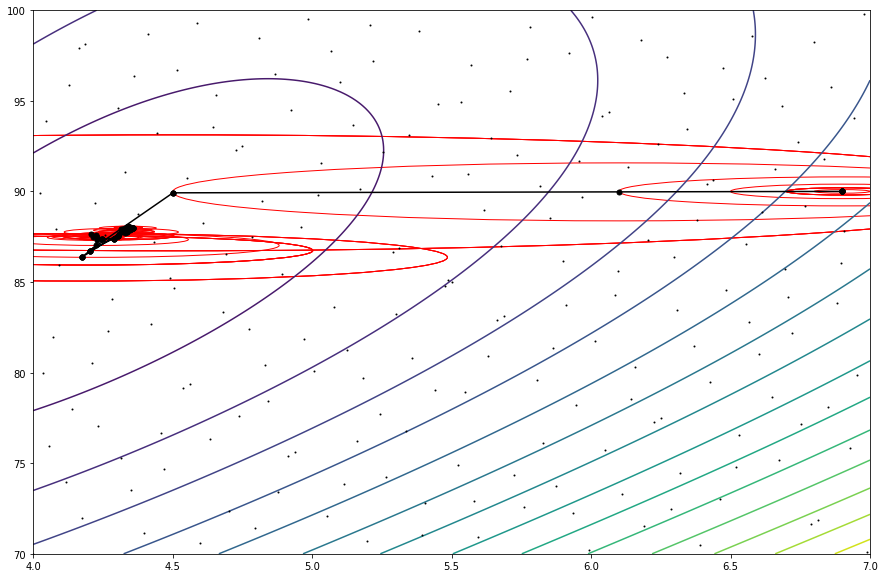

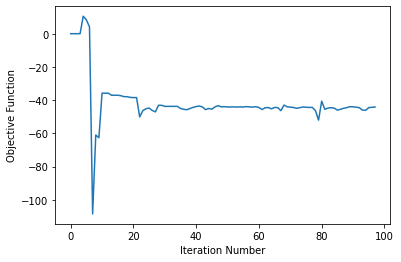

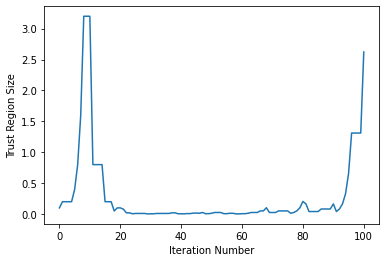

In [ ]:
print('Optimum points are: '+ str(x_k))

#plotting f_approx
# setting up plot
x_1      = np.linspace(4, 7, n_s)         
x_2      = np.linspace(70, 100, n_s)
x        = [[x,y] for x in x_1 for y in x_2]
x        = np.array(x)
x        = x.T
plt = matplotlib.pyplot
fig = plt.figure()
# Contour plot
# f_copy = obj_system(x).reshape((n_s,n_s))

plot_sample = np.zeros(x.shape[1]);
for i in range(x.shape[1]):
  plot_sample[i] = obj_system_noiseless(x[:,i]);

f_copy = plot_sample.reshape((n_s, n_s), order="F")

# plotting objective
def simplefunc_plot(x, model_coeffs):
    return model_coeffs[0]*x[0,:]**2 + model_coeffs[1]*x[1,:]**2 + model_coeffs[2]*x[0,:]+ model_coeffs[3]*x[1,:] +model_coeffs[4] # (CHANGE MANUALLY)
f = simplefunc_plot(x,model_coeffs+ef_coeffs)


fig, ax  = plt.subplots(figsize=(15,10))
CS       = ax.contour(x_1, x_2, (f_copy), 15)
ax.plot(x_sample[0,:], x_sample[1,:], 'ko', markersize=1)
#ax.plot(g11x2Simple_plot, x_2, 'k')
ax.plot(x_new_plot[:,0], x_new_plot[:,1], 'ko-', markersize=5)

for i in range(n_i - 1):
  c = plt.Circle((x_new_plot[i, :]), delta_plot[i], color='r', fill=False)
  ax.add_artist(c)

axes = plt.gca()
axes.set_xlim([4,7])
axes.set_ylim([70,100])

plt.show()
obj_fun_plot = np.delete(obj_fun_plot, (0), axis=0)
plt.plot(obj_fun_plot)
plt.ylabel('Objective Function')
plt.xlabel('Iteration Number')
plt.show()

plt.plot(delta_plot)
plt.ylabel('Trust Region Size')
plt.xlabel('Iteration Number')
plt.show()
